# Viola-Jones like MNIST classifier

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

import itertools

## Loading MNIST

In [2]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip -k *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [3]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.astype('float32')

### for simplicity we consider only binary classification
### one digit vs the rest
target_digit = 8

### AdaBoost is naturally defined for y = {-1, 1}
y = np.where(y == target_digit, 1, -1).astype('int8')

### to balance outnumbers target we assign weights
### sum of all weights for y == 1 quals to sum of these for y == -1
w = np.where(y == 1, 1.0, 1.0 / 9.0).astype('float32')
w = w / np.sum(w)

### The same for test dataset
X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.astype('float32')

y_test = np.where(y_test == target_digit, 1, -1).astype('int8')

w_test = np.where(y_test == 1, 1.0, 1.0 / 9.0).astype('float32')
w_test = w_test / np.sum(w_test)

In [4]:
print X.shape, y.shape, w.shape
print X.dtype, y.dtype, w.dtype

(60000, 28, 28) (60000,) (60000,)
float32 int8 float32


We will perform very simple convolutions. To speed up convolution computation,
integral images are computed:
$$I_{x, y} = \sum_{i \leq x, j \leq y } X_{i, j}$$

where:
- $X$ - original image;
- $I$ - integral image.

Essentially, it is just two sequential `cumsum`.

In [5]:
X_ii = np.cumsum(np.cumsum(X, axis=1), axis=2)
X_ii_test = np.cumsum(np.cumsum(X_test, axis=1), axis=2)

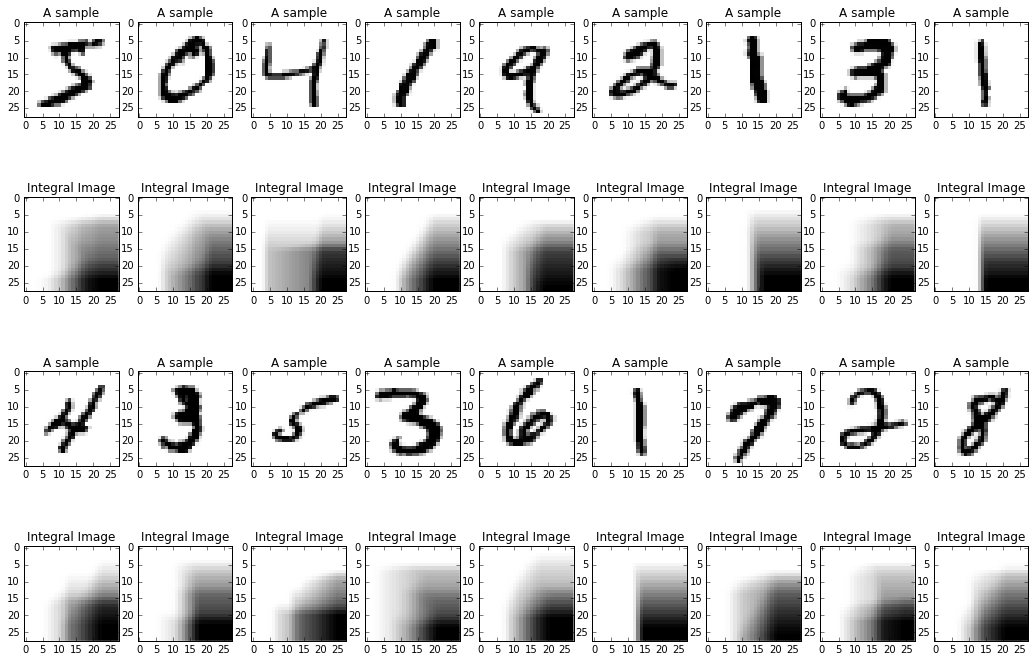

In [6]:
nrows, ncols = 2, 9
fig, ax = plt.subplots(nrows * 2, ncols, figsize=(ncols * 2, (nrows + 1) * 2 * 2))

for i, j in itertools.product(range(nrows), range(ncols)):
    indx = i * ncols+ j
    
    ax[i * 2, j].imshow(
        X[indx],
        interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
    )
    ax[i * 2, j].set_title('A sample')
    
    ax[i * 2 + 1, j].imshow(
        X_ii[indx],
        interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=np.max(X_ii[indx])
    )
    ax[i * 2 + 1, j].set_title('Integral Image')

## AdaBoost on Haar-like features

### Haar-like features

Haar-like features (filters) are rectanglar convolutional filters with value 1 inside, 0 outside.
Unlike most of convolutions, Haar-like filters allow extremely fast computation scheme. Since a filter is basically a sum inside a rectangle, it can be computed in 4 operations using precomputed integral images:
$$H(x_1, y_1, x_2, y_2) = I_{x_2, y_2} - I_{x_1, y_2} - I_{x_2, y_1} + I_{x_1, y_1}$$

For real-world applications more complex Haar-like filters are used (i.e. set of rectangles), but for simplicity we consider only rectangular ones.

In [7]:
def haar_conv(ii, filters):
    """
    Computes convolution of integral images `ii` with filters `filters`.

    Parameters
    ----------
    ii : 3D tensor, (n_images, width, height)
        Integral images to be convolved with.

    filters : 3D tensor, (n_filters, 2, 2)
        Haar-like convolutional filters.
        Each filter is defined by 2 2D points:
          [[x1, y1],
           [x2, y2]]

    Returns
    -------
    matrix, (n_images, n_filters)
        result of convolution of each filter with each image normed on filter's area.
    """
    S = (filters[:, 1, 0] - filters[:, 0, 0]) * (filters[:, 1, 1] - filters[:, 0, 1])
    conv = ii[:, filters[:, 1, 0], filters[:, 1, 1]] - \
           ii[:, filters[:, 0, 0], filters[:, 1, 1]] - \
           ii[:, filters[:, 1, 0], filters[:, 0, 1]] + \
           ii[:, filters[:, 0, 0], filters[:, 0, 1]]
    
    return conv / S

In [8]:
def exp_loss(f, y, sample_weights):
    """
    Just shortcut for exponential loss.
    """
    return sample_weights * np.exp(-f * y)

In [9]:
def generate_random_filters(n, width, height):
    """
    Generates random Haar-like filters for images with size (width, height)
    For simplicity of generation, first points (x1, y1) are distributed uniformly on image,
    while ending points are distributed unifomely on [x1, width) or [y1, height).
    Thus, in general, this procedure favors small filters.
    """
    filters = np.zeros(shape=(n, 2, 2), dtype='int32')
    filters[:, 0, 0] = np.random.randint(0, width-1, size=n)
    filters[:, 0, 1] = np.random.randint(0, height-1, size=n)

    delta_x = width - filters[:, 0, 0] - 1
    delta_y = height - filters[:, 0, 1] - 1
 
    filters[:, 1, 0] = filters[:, 0, 0] + np.floor(np.random.uniform(size=n) * delta_x).astype('int32') + 1
    filters[:, 1, 1] = filters[:, 0, 1] + np.floor(np.random.uniform(size=n) * delta_y).astype('int32') + 1

    return filters

Since AdaBoost constructs a linear combination of underlying classifiers, and each filter is a linear combination of image pixels, in order to build model wider than linear separations, we must add some non-linearity to base classifiers. If $s(x)$ is convolution of Haar-like filter with image, one the simplest non-linear classifiers:

$$f(x) = \begin{cases} a, & \text{if}\,s(x) > \tau;\\b, &\text{otherwise}. \end{cases}$$

Hence, given a Haar-like filter $s$, a model for classifier $f(x)$ can be constructed from $s$; training procedure is equalent to selecting optimal $a$, $b$ and $\tau$.

In [10]:
def classifiers_scores(X, filters, threshold, neg, pos):
    """
    Computes classifiers scores of integral images `X` with filters `filters`.

    Parameters
    ----------
    ii : 3D tensor, (n_images, width, height)
        Integral images to be convolved with.

    filters : 3D tensor, (n_filters, 2, 2)
        Haar-like convolutional filters.
        Each filter is defined by 2 2D points:
          [[x1, y1],
           [x2, y2]]
    
    threshold: array,
        Thresholds for each filter. If convolution of the filter with an image
        exceeds this threshold, the score is set to `pos`, otherwise to `neg`.
    pos: array,
        positive votes for classfiers
    neg: array:
        negative votes for classifiers
    Returns
    -------
    matrix, (n_images, n_filters)
        scores of each classifiers.
    """
    conv = haar_conv(X, filters)
    return np.where(conv > threshold, pos, neg)

Using exponential loss with weights:
$$L = \sum_i w_i \exp(-y_i f(x_i))$$

one can show that optimal parameters for filter $s$ is:
$$L^*(\tau) = 2 \left[ \sqrt{\left( \sum_{i \in TN(\tau)} w_i \right) \left( \sum_{i \in FN(\tau)} w_i \right) } + \sqrt{\left( \sum_{i \in FP(\tau)} w_i \right) \left( \sum_{i \in TP(\tau)} w_i \right) } \right]$$

where $TN(\tau)$ - indices of __t__rue __n__egative samples (given threshold $\tau$), etc.

Optimal votes:

$$a = \frac{1}{2}\log \left[ \frac{\sum_{i \in TP(\tau)} w_i}{\sum_{i \in FP(\tau)} w_i} \right]$$

$$b = -\frac{1}{2}\log \left[ \frac{\sum_{i \in TN(\tau)} w_i}{\sum_{i \in FN(\tau)} w_i} \right]$$

In [11]:
def fit_classifiers(filters, X, y, w, C = 1.0e-1, subset=None):
    """
    Computes classifiers scores of integral images `X` with filters `filters`.

    Parameters
    ----------
    ii : 3D tensor, (n_images, width, height)
        Integral images to be convolved with.

    filters : 3D tensor, (n_filters, 2, 2)
        Haar-like convolutional filters.
        Each filter is defined by 2 2D points:
          [[x1, y1],
           [x2, y2]]
    
    threshold: array,
        Thresholds for each filter. If convolution of the filter with an image
        exceeds this threshold, the score is set to `pos`, otherwise to `neg`.
    pos: array,
        positive votes for classfiers
    neg: array:
        negative votes for classifiers
    Returns
    -------
    matrix, (n_images, n_filters)
        scores of each classifiers.
    """
    if subset is not None:
        n = int(subset * X.shape[0])
        train_indx = np.random.choice(X.shape[0], size=n, replace=False)

        X = X[train_indx]
        y = y[train_indx]
        w = w[train_indx]
    
    conv = haar_conv(X, filters)
    indx = np.argsort(conv, axis=0)
    
    id_filter_selection = np.arange(conv.shape[1])

    tn = np.cumsum((y[indx] == -1) * w[indx], axis=0)
    fn = np.cumsum((y[indx] == 1) * w[indx], axis=0)

    r_indx = indx[::-1, :]
    
    tp = np.cumsum((y[r_indx] == 1) * w[r_indx], axis=0)[::-1, :]
    fp = np.cumsum((y[r_indx] == -1) * w[r_indx], axis=0)[::-1, :]
    
    loss = 2 * (np.sqrt(tp * fp) + np.sqrt(tn * fn))
    
    optimal_threshold_index = np.argmin(loss, axis=0)
    
    thr_optimal = conv[indx[optimal_threshold_index, id_filter_selection], id_filter_selection]
    
    tp_optimal = tp[optimal_threshold_index, id_filter_selection]
    tn_optimal = tn[optimal_threshold_index, id_filter_selection]
    
    fp_optimal = fp[optimal_threshold_index, id_filter_selection]
    fn_optimal = fn[optimal_threshold_index, id_filter_selection]
    
    neg_vote = -np.log((tn_optimal + C) / (fn_optimal + C)) / 2
    pos_vote = np.log((tp_optimal + C) / (fp_optimal + C)) / 2
    
    # minimal_loss = loss[optimal_threshold_index, id_filter_selection]
    scores = np.where(conv > thr_optimal, pos_vote, neg_vote)
    
    ### Due to discrete nature of this filters
    ### sometimes estimated loss is actually much lower than actual one.
    ### Usually it happens when all scores of filter are zeros.
    actual_loss = np.sum(np.exp(-scores * y[:, None]) * w[:, None], axis=0)
    
    return thr_optimal, neg_vote, pos_vote, actual_loss

In [12]:
filters = generate_random_filters(2**8, 28, 28)

In [13]:
%%time

thr, neg, pos, loss = fit_classifiers(filters, X_ii, y, w)

CPU times: user 5.03 s, sys: 574 ms, total: 5.61 s
Wall time: 5.61 s


In [23]:
class HaarBoost(object):
    """
    AdaBoost on Haar-like filters.
    """
    def __init__(self, n_filters = 32, n_selection=256,
                 train_subset = 0.1, C = 1.0,
                 learning_rate = 1.0):
        """
        AdaBoost on Haar-like filters.

        Parameters
        ----------
        n_filters : int,
            number of classifiers (filters) in ensemble.

        n_selection : int,
            number of candidate filters to randomly generate.

        train_subset: float,
            fraction of sample to use for classifiers training.
            Training set is randomly selected on each step.
            
        C: float,
            regularization coefficient for classifier's votes.
            
        learning_rate: float:
            include classifier with `learning_rate` weight.
            Useful with low `training_subset`.
        """
        self.n_filters = n_filters
        self.n_selection = n_selection
        self.train_subset = train_subset
        self.C = C
        
        self.ensemble_filters = np.zeros(shape=(n_filters, 2, 2), dtype='int32')
        self.ensemble_threshold = np.zeros(shape=n_filters, dtype='float32')
        self.ensemble_pos = np.zeros(shape=n_filters, dtype='float32')
        self.ensemble_neg = np.zeros(shape=n_filters, dtype='float32')
        
        self.learning_rate = learning_rate
    
    def select_filter(self, X, y, w):
        random_filters = generate_random_filters(self.n_selection, X.shape[1], X.shape[2])
        thrs, negs, poss, losses = fit_classifiers(
            random_filters,
            X, y, w,
            C=self.C, subset=self.train_subset
        )
        
        best = np.argmin(losses)
        
        return random_filters[best], thrs[best], negs[best], poss[best], losses[best]
    
    def ensemble_staged_score(self, X):
        scores = classifiers_scores(
            X,
            self.ensemble_filters, self.ensemble_threshold,
            self.ensemble_neg, self.ensemble_pos
        )
        
        return np.cumsum(scores, axis=1)

    def ensemble_score(self, X):
        scores = classifiers_scores(
            X,
            self.ensemble_filters, self.ensemble_threshold,
            self.ensemble_neg, self.ensemble_pos
        )
        
        return np.sum(scores, axis=1)
    
    def fit(self, X, y, sample_weights=None):
        self.ensemble_pos[:] = 0.0
        self.ensemble_neg[:] = 0.0
        self.ensemble_threshold[:] = 0.0
        
        train_curve = np.zeros(shape=self.n_filters)

        i = 0
        miss_step = 0
        n_max_miss_step = 10
        
        start_time = 0.0
        end_time = 0.0

        while i < self.n_filters:
            ensemble_scores = self.ensemble_score(X)
            ensemble_losses = exp_loss(ensemble_scores, y, sample_weights)
            ensemble_loss = np.sum(ensemble_losses)
            
            filter, thr, neg, pos, loss = self.select_filter(X, y, ensemble_losses)

            if loss < ensemble_loss:
                self.ensemble_filters[i] = filter
                self.ensemble_threshold[i] = thr
                self.ensemble_neg[i] = neg * self.learning_rate
                self.ensemble_pos[i] = pos * self.learning_rate
                train_curve[i] = ensemble_loss
                
                i += 1
                miss_step = 0
                
                if i % 5 == 0:
                    print '%d classfier selected' % i
            elif miss_step >= n_max_miss_step:
                print 'Early stopping, no candidates for %d steps' % miss_step
                break
            else:
                print 'No candidate for classifier %d (try %d)' % (i, miss_step)
                miss_step += 1

        return train_curve
        
    def predict(self, X):
        return self.ensemble_score(X)
    
    def staged_predict(self, X):
        return self.ensemble_staged_score(X)

In [24]:
clf = HaarBoost(n_filters=32, n_selection=256, train_subset=1.0, C=1.0e-3, learning_rate=1.0)

In [25]:
%%time

losses = clf.fit(X_ii, y, sample_weights=w)

5 classfier selected
10 classfier selected
15 classfier selected
20 classfier selected
25 classfier selected
30 classfier selected
CPU times: user 2min 37s, sys: 20.1 s, total: 2min 58s
Wall time: 2min 58s


/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


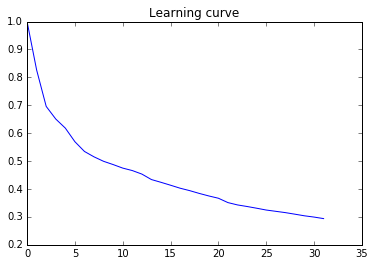

In [26]:
plt.title("Learning curve")
plt.plot(losses)

### Evaluation

In [27]:
proba = clf.staged_predict(X_ii_test)

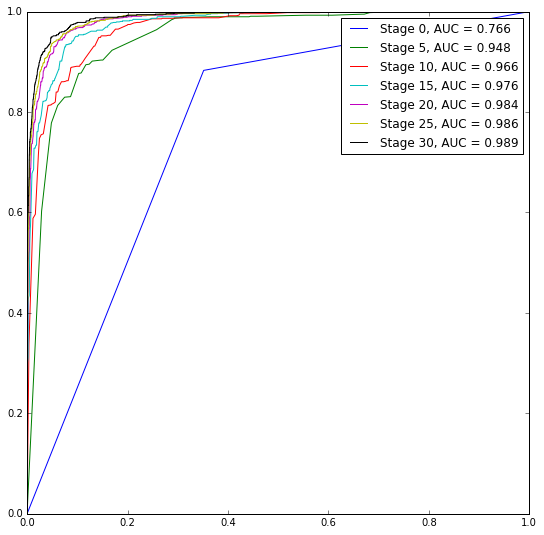

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(9, 9))
plt.plot([0, 0], [1, 1], '--', color='black')

for i in xrange(0, proba.shape[1], 5):
    fpr, tpr, _ = roc_curve(y_test, proba[:, i])
    s = roc_auc_score(y_test, proba[:, i])

    plt.plot(fpr, tpr, label='Stage %d, AUC = %.3lf' % (i, s))

plt.legend()
plt.show()

### Visualization of classifiers

In [29]:
fs = clf.ensemble_filters

filters_pos = np.zeros(shape=(fs.shape[0], X.shape[1], X.shape[2]), dtype='float32')
filters_neg = np.zeros(shape=(fs.shape[0], X.shape[1], X.shape[2]), dtype='float32')
filters_thr = np.zeros(shape=(fs.shape[0], X.shape[1], X.shape[2]), dtype='float32')

for i in xrange(fs.shape[0]):
    fp = np.zeros(shape=(X.shape[1], X.shape[2]), dtype='float32')
    fn = np.zeros(shape=(X.shape[1], X.shape[2]), dtype='float32')
    ft = np.zeros(shape=(X.shape[1], X.shape[2]), dtype='float32')

    sx, sy = fs[i, 0, :]
    ex, ey = fs[i, 1, :]
    
    fp[sx:ex, :][:, sy:ey] = clf.ensemble_pos[i]
    fn[sx:ex, :][:, sy:ey] = clf.ensemble_neg[i]
    ft[sx:ex, :][:, sy:ey] = clf.ensemble_threshold[i]
    
    filters_pos[i] = fp
    filters_neg[i] = fn
    filters_thr[i] = ft

In [30]:
vmin = np.min(filters_neg)
vmax = np.max(filters_pos)

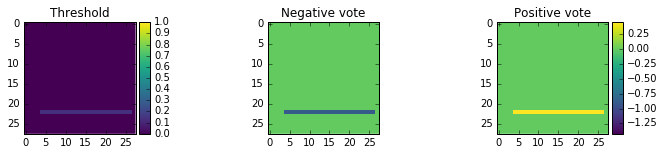

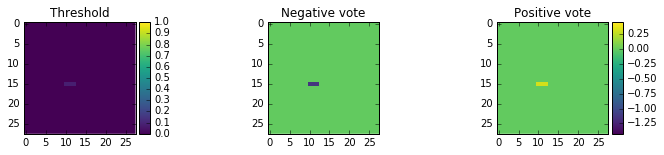

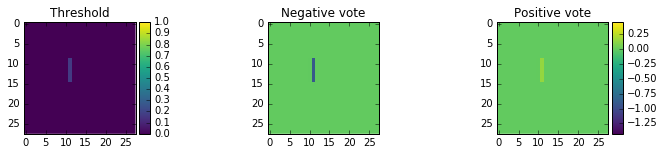

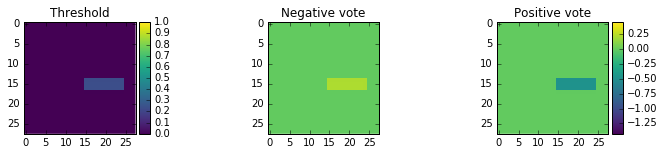

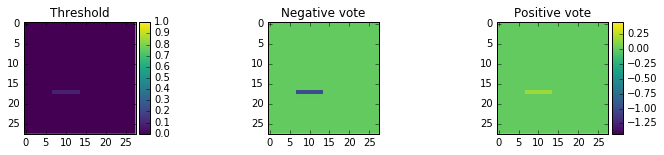

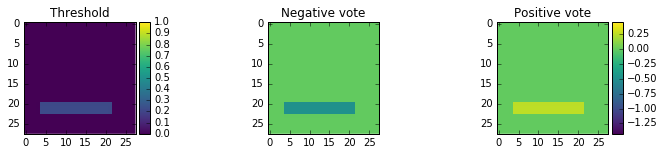

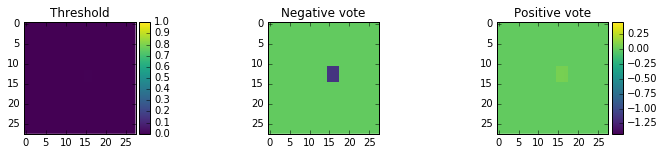

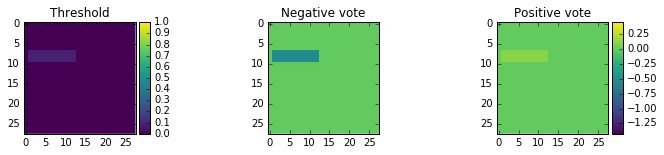

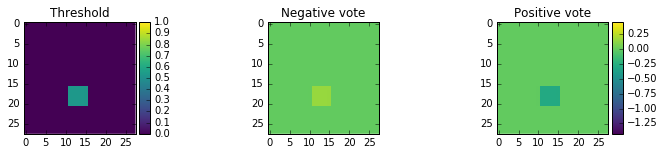

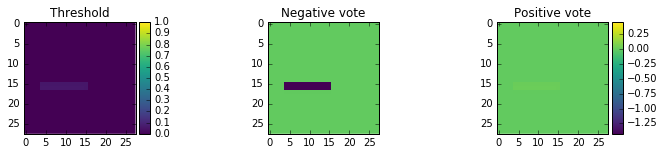

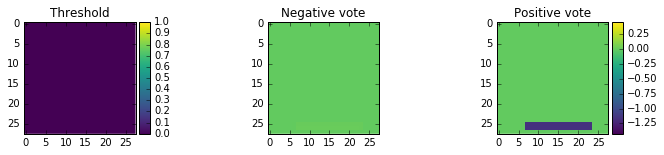

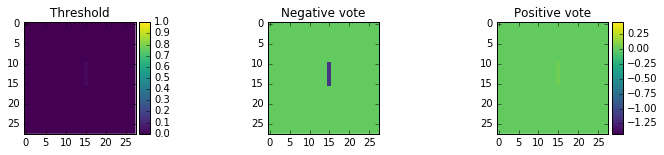

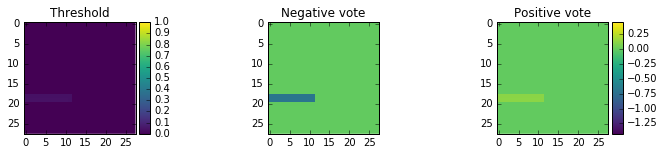

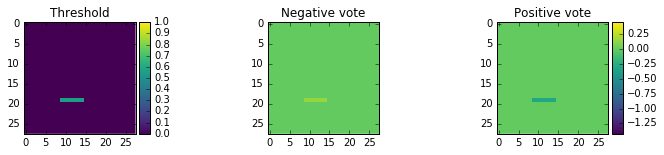

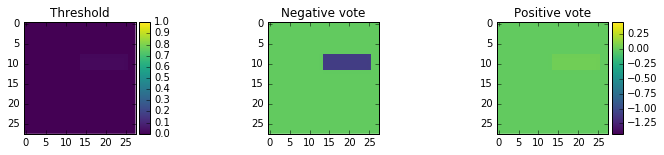

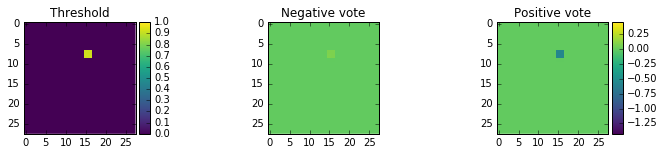

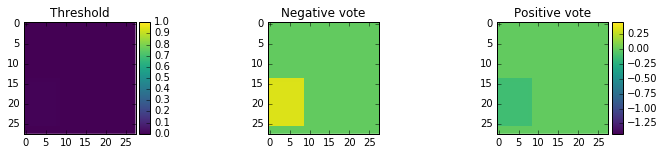

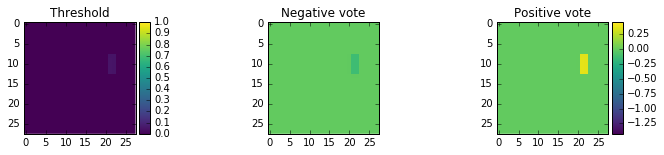

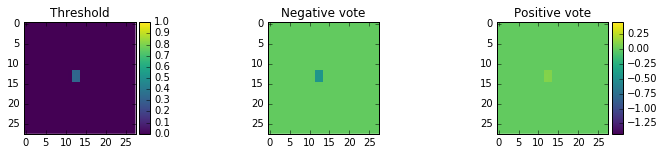

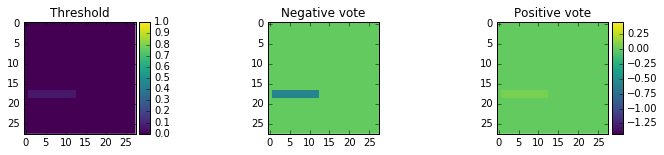

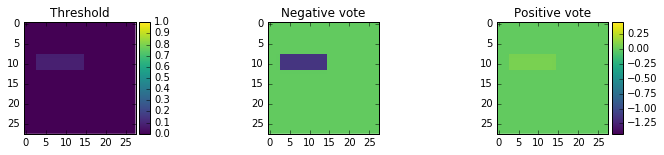

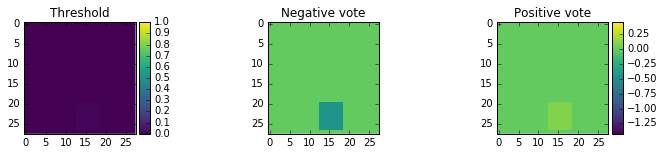

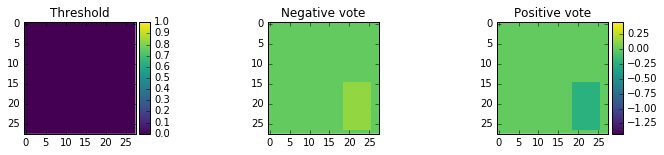

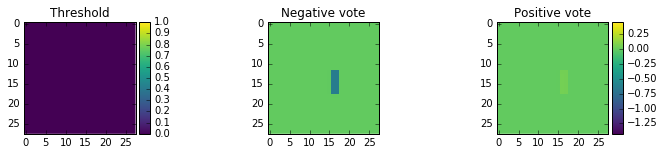

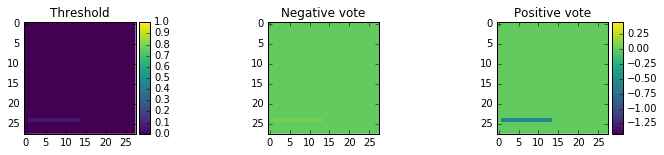

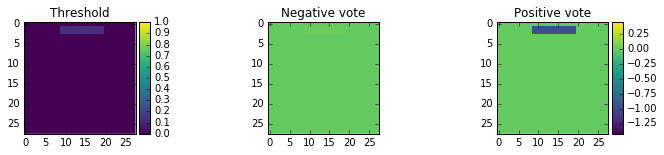

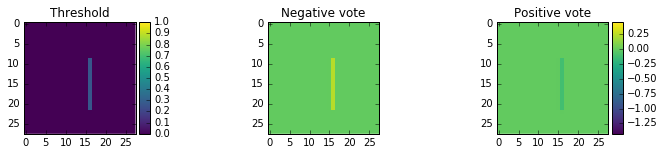

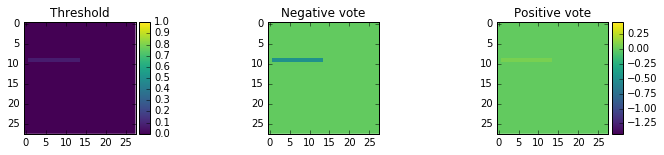

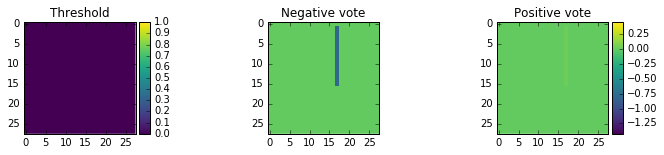

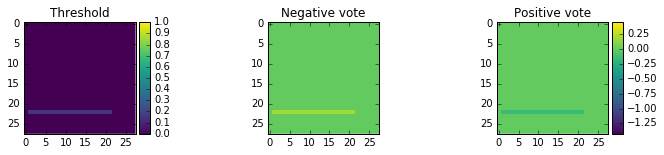

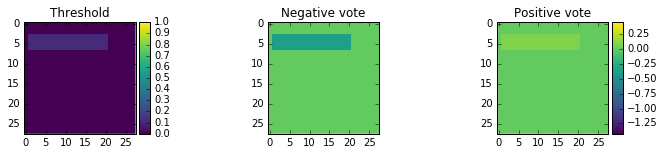

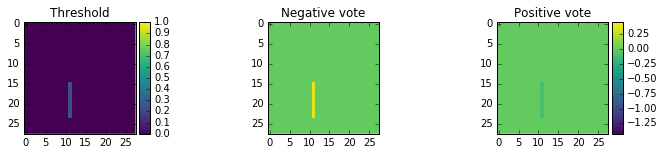

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

for i in xrange(fs.shape[0]):
    f, ax = plt.subplots(1, 3, figsize=(12, 2))
    
    im = ax[0].imshow(filters_thr[i], cmap=plt.cm.viridis, interpolation='None', vmin=0, vmax=1)
    ax[0].set_title('Threshold')
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    #f.colorbar(im)
    
    im = ax[1].imshow(filters_neg[i], cmap=plt.cm.viridis, interpolation='None', vmin=vmin, vmax=vmax)
    ax[1].set_title('Negative vote')
    
    im = ax[2].imshow(filters_pos[i], cmap=plt.cm.viridis, interpolation='None', vmin=vmin, vmax=vmax)
    ax[2].set_title('Positive vote')
    
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    
    plt.show()

In [ ]:
plt.title('Filters superimposed')

plt.figure(figsize=(6, 4))
plt.imshow(np.sum(filters_pos, axis=0), interpolation='None', cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 4))
plt.imshow(np.sum(filters_neg, axis=0), interpolation='None', cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

## Bonus: globally optimized perceptron

Essentially, AdaBoost greadily builds a perceptron.
Here we build a smooth version of ensemble on the same type of features.

In [34]:
%env OMP_NUM_THREADS=32
%env THEANO_FLAGS='device=cpu','openmp=True', 'floatX=float32'

import theano
import theano.tensor as T
import lasagne

env: OMP_NUM_THREADS=32
env: THEANO_FLAGS='device=cpu','openmp=True', 'floatX=float32'


/opt/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [127]:
batch_indx = T.ivector('batch index')

filters = generate_random_filters(64, 28, 28)

conv = theano.shared(
    haar_conv(X_ii, filters).astype('float32'),
    name = 'convs'
)

conv_batch = conv[batch_indx]

weights = theano.shared(
    w.astype('float32'),
    name = 'weigths'
)

weights_batch = weights[batch_indx]

labels = theano.shared(
    y.astype('float32'),
    name = 'labels'
)

labels_batch = labels[batch_indx]

n_filters = filters.shape[0]

thr = theano.shared(
    np.random.uniform(0.1, 0.9, size=n_filters).astype('float32'),
    name = 'thr'
)

offset = theano.shared(np.array(0.0, dtype='float32'), name='offset')

alphas = theano.shared(
    np.ones(n_filters, dtype='float32') / n_filters,
    name = 'mixin coefs'
)

votes = T.nnet.sigmoid(conv_batch - thr[None, :])

predictions = T.sum(votes * alphas[None, :] + offset, axis=1)

c_reg = T.fscalar('C_reg')
#predictions = predictions.reshape((predictions.shape[0], ))

pure_loss = T.sum(weights_batch * T.exp(-predictions * labels_batch)) / T.sum(weights_batch)
loss = pure_loss + c_reg + T.mean(abs(alphas))

In [128]:
from lasagne import updates

In [129]:
learning_rate = T.fscalar('learning rate')

upd = updates.sgd(loss, [thr, offset, alphas], learning_rate = learning_rate)

In [130]:
predict= theano.function([batch_indx], predictions)

In [131]:
predict([1, 2, 3,])

array([ 0.43086722,  0.4096536 ,  0.41774783], dtype=float32)

In [132]:
train = theano.function([batch_indx, learning_rate, c_reg], [pure_loss, loss], updates=upd)

In [133]:
def batch_stream(N, batches, batch_size):
    for i in xrange(batches):
        yield np.random.choice(N, size=batch_size).astype('int32')

In [ ]:
conv.set_value(
    haar_conv(X_ii, filters).astype('float32')
)

epoches = 100
steps = 500

plot_each = 10

losses = []

c_reg = np.array(1.0e-1, dtype='float32')

for epoch in xrange(epoches):
    epoch_losses = []
    for i, indx in enumerate(batch_stream(X_ii.shape[0], steps, batch_size=2**10)):
        pl, l = train(indx, np.array(5.0e-2, dtype='float32'), c_reg)
        epoch_losses.append(pl)

    losses.append(np.mean(epoch_losses))
    
    if (epoch + 1) % plot_each == 0:
        plt.figure()
        plt.plot(losses)
        plt.show()

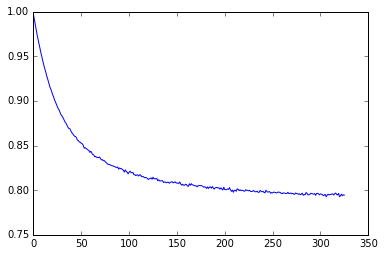

In [93]:
plt.figure()
plt.plot(losses)
plt.show()

In [94]:
conv.set_value(haar_conv(X_ii_test, filters).astype('float32'))
prediction = predict(np.arange(X_ii_test.shape[0], dtype='int32'))

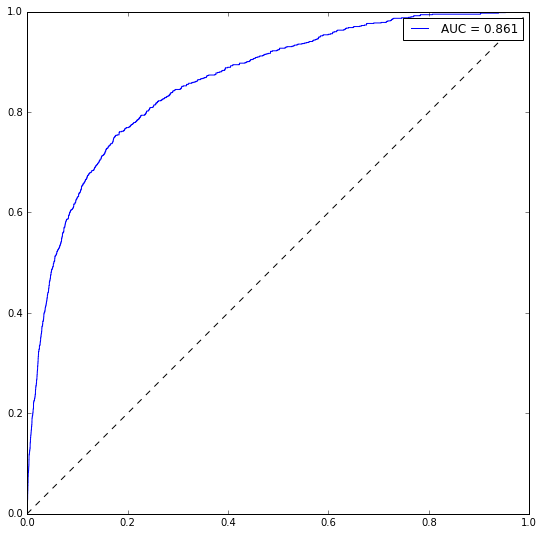

In [96]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(9, 9))
plt.plot([0, 1], [0, 1], '--', color='black')

fpr, tpr, _ = roc_curve(y_test,prediction)
s = roc_auc_score(y_test, prediction, sample_weight=w_test)

plt.plot(fpr, tpr, label='AUC = %.3lf' % s)

plt.legend()
plt.show()